# Cognition and Computation Project

## Import Libraries

In [1]:
import os
import math
import json
import random
import requests

from IPython.display import display, clear_output
from urllib.parse import quote

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import scipy
import pandas as pd
import numpy as np
import seaborn as sns

## Dataset

[The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset)

```quote
The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The drawings were captured as timestamped vectors, tagged with metadata including what the player was asked to draw and in which country the player was located.
```

### Selected Categories

Original categories list was divided into 10 broad categories that are stored in the `categories.json` file.

In [2]:
DATASET_BASE_URL = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
IMG_SHAPE = (28, 28)
RANDOM_SEED = 123
BATCH_SIZE = 32

categories_json_filename = 'categories.json'

In [4]:
# Downloading categories
# %%capture
!wget -O {categories_json_filename} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/data/{categories_json_filename}"

--2026-01-08 15:29:52--  https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/data/categories.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6018 (5.9K) [text/plain]
Saving to: ‘categories.json’

categories.json     100%[===================>]   5.88K  --.-KB/s    in 0s      

2026-01-08 15:29:52 (58.7 MB/s) - ‘categories.json’ saved [6018/6018]



In [5]:
categories_json = {}
with open(categories_json_filename, 'r') as f:
    categories_json = json.load(f)

display(categories_json)

{'Animals': ['ant',
  'bat',
  'bear',
  'bee',
  'bird',
  'camel',
  'cat',
  'cow',
  'crab',
  'crocodile',
  'dog',
  'dolphin',
  'dragon',
  'duck',
  'elephant',
  'fish',
  'flamingo',
  'frog',
  'giraffe',
  'hedgehog',
  'horse',
  'kangaroo',
  'lion',
  'lobster',
  'monkey',
  'mosquito',
  'mouse',
  'octopus',
  'owl',
  'panda',
  'parrot',
  'penguin',
  'pig',
  'rabbit',
  'raccoon',
  'rhinoceros',
  'scorpion',
  'sea turtle',
  'shark',
  'sheep',
  'snail',
  'snake',
  'spider',
  'squirrel',
  'swan',
  'teddy-bear',
  'tiger',
  'whale',
  'zebra'],
 'Transport': ['aircraft carrier',
  'airplane',
  'ambulance',
  'bicycle',
  'bulldozer',
  'bus',
  'canoe',
  'car',
  'cruise ship',
  'firetruck',
  'helicopter',
  'hot air balloon',
  'motorbike',
  'pickup truck',
  'police car',
  'sailboat',
  'school bus',
  'speedboat',
  'submarine',
  'tractor',
  'train',
  'truck',
  'van'],
 'Food_Plants': ['apple',
  'asparagus',
  'banana',
  'blackberry',
  '

In [6]:
def get_quickdraw_data(categories_json, total_classes=5, samples_per_class=2000, seed=123):
    """
    categories_json: dict {SuperCategory: [list of subcategories]}
    total_classes: total number of classes to sample
    samples_per_class: number of samples to download per class
    """
    selected_classes = []

    random.seed(seed)

    # 1. Hierarchical Sampling
    pool = {k: list(v) for k, v in categories_json.items()}
    while len(selected_classes) < total_classes:
        broad_cats = [c for c, items in pool.items() if len(items) > 0]
        if not broad_cats:
            break

        # Uniformly select broad category
        broad_cat = random.choice(broad_cats)

        # Uniformly sample sub-category
        sub_cat = random.choice(pool[broad_cat])

        selected_classes.append((sub_cat, broad_cat))

        # Exclude sampled sub-category from further sampling
        pool[broad_cat].remove(sub_cat)

    # 2. Downloading data
    X, Y, Y_super = [], [], []

    for i, (sub_cat, broad_cat) in enumerate(selected_classes):
        file_name = f'{quote(sub_cat)}.npy'
        url = DATASET_BASE_URL + file_name

        print(f'Downloading {sub_cat} ({broad_cat})...')
        res = requests.get(url)
        data = np.frombuffer(
            res.content, dtype=np.uint8, offset=80
        )
        data = data.reshape(-1, math.prod(IMG_SHAPE))[:samples_per_class]

        X.append(data)
        Y.append(np.full(len(data), i))  # Sub-class label (from 0 to total_classes-1)

        # Numerical label for broad category
        Y_super.append(
            [list(categories_json.keys()).index(broad_cat)] * len(data)
        )

    X = np.concatenate(X) / 255.0  # Normalize [0,1]
    Y = np.concatenate(Y)

    return torch.FloatTensor(X), torch.LongTensor(Y), selected_classes

In [52]:
# Downloading previously used data
%%capture
quickdraw_data_filename = 'quickdraw_data.npz'

!wget -O {quickdraw_data_filename} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/data/{quickdraw_data_filename}"

loaded_data = np.load(quickdraw_data_filename, allow_pickle=True)

sketch_data = torch.from_numpy(loaded_data['data'])
sketch_labels = torch.from_numpy(loaded_data['labels'])
sketch_categories = loaded_data['categories'].tolist()

In [7]:
# Sampling new data
sketch_data, sketch_labels, sketch_categories = get_quickdraw_data(
    categories_json, total_classes=5, samples_per_class=2000, seed=RANDOM_SEED
)

In [51]:
# Saving sampled data
quickdraw_data_filename = 'quickdraw_data.npz'

save_data = sketch_data.numpy()
save_labels = sketch_labels.numpy()
save_categories = np.array(sketch_categories, dtype=object)

np.savez_compressed(
    quickdraw_data_filename,
    data=save_data,
    labels=save_labels,
    categories=save_categories
)

In [27]:
def show_img(
    img, sub_category=None, broad_category=None, predicted_sub_category=None, predicted_broad_category=None
):
    if sub_category is not None:
        print(f'Sub-category: {sub_category}')
    if broad_category is not None:
        print(f'Broad category: {broad_category}')
    if predicted_sub_category is not None:
        print(f'Predicted sub-category: {predicted_sub_category}')
    if predicted_broad_category is not None:
        print(f'Predicted broad category: {predicted_broad_category}')
    img = img.cpu()
    plt.imshow(img, cmap='gray')
    plt.show()


def show_class_distribution(labels, categories):
    counts = pd.Series(labels.numpy()).value_counts().sort_index()

    df_meta = pd.DataFrame(
        categories, columns=['sub_category', 'broad_category']
    )
    df_meta['samples'] = counts.values

    sns.set_theme(style='whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(
        data=df_meta,
        x='sub_category', y='samples', hue='broad_category',
        palette='viridis', dodge=False, legend=False, ax=axes[0]
    )
    axes[0].set_title('Samples per Sub-Category')
    axes[0].tick_params(axis='x', rotation=45)

    sns.barplot(
        data=df_meta.groupby('broad_category')['samples'].sum().reset_index(),
        x='broad_category', y='samples', hue='broad_category',
        palette='magma', legend=False, ax=axes[1]
    )
    axes[1].set_title('Samples per Broad Category')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

Sub-category: frog
Broad category: Animals


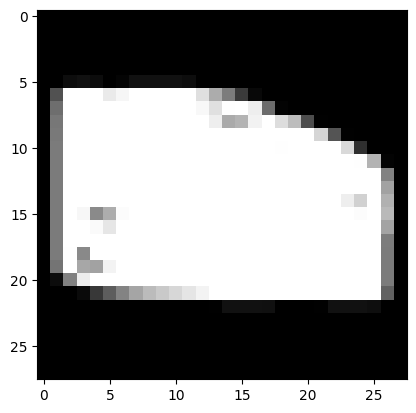

In [9]:
img_idx = 1501
img = sketch_data[img_idx]
label = sketch_labels[img_idx]
sub_category, broad_category = sketch_categories[label]

show_img(
    img.reshape(IMG_SHAPE),
    sub_category=sub_category,
    broad_category=broad_category
)

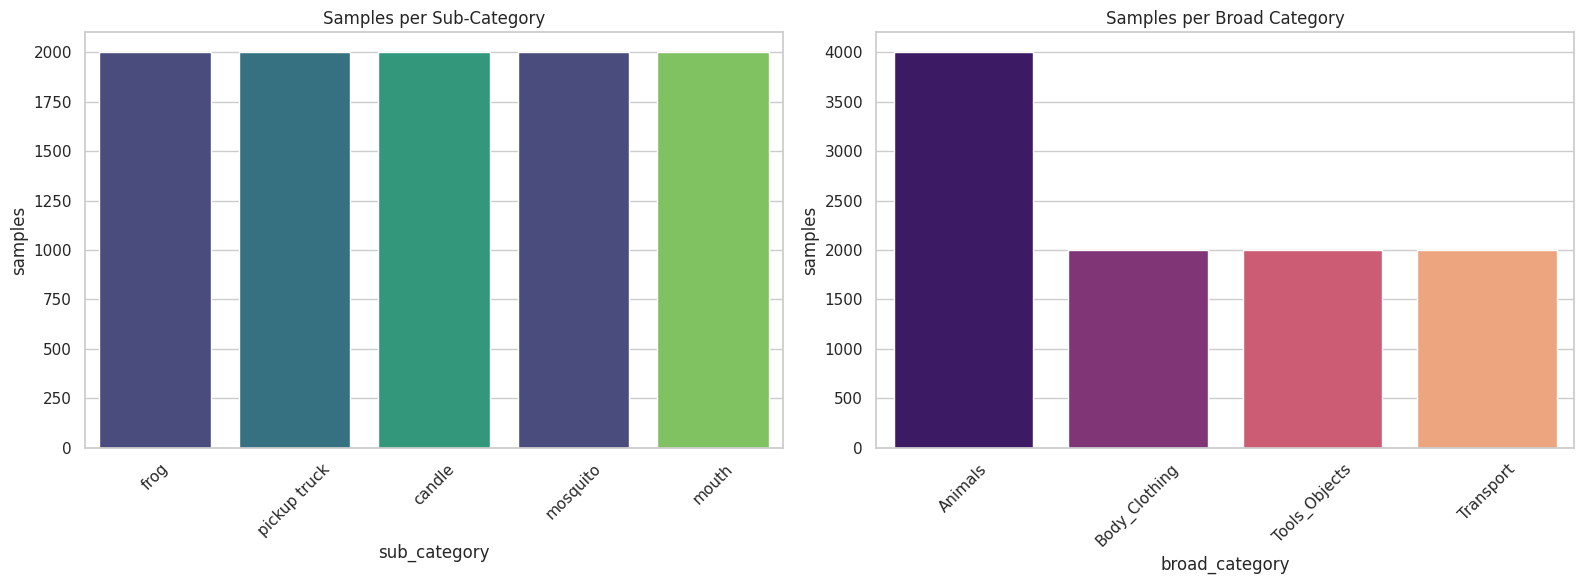

In [28]:
show_class_distribution(sketch_labels, sketch_categories)

In [24]:
# Create train and test dataloaders
train_size = int(0.8 * len(sketch_data))
test_size = len(sketch_data) - train_size

train_data, test_data = torch.utils.data.random_split(
    sketch_data, [train_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

train_labels, test_labels = torch.utils.data.random_split(
    sketch_labels, [train_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

train_dataset = TensorDataset(
    train_data.dataset[train_data.indices],
    train_labels.dataset[train_labels.indices]
)
test_dataset = TensorDataset(
    test_data.dataset[test_data.indices],
    test_labels.dataset[test_labels.indices]
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

print(f'Using device: {device_name}')

Training dataset size: 8000
Test dataset size: 2000
Using device: cpu
